# GRAD-E1426 Network Analysis: Assignment 2 
#### Janine De Vera, 219848

In [3]:
import graph_tool.all as gt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import math


In [4]:
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Semester 4/2 Network Analysis/Assignments/network-analysis-trade-agreements/code'

## I. Prepare Data

For this exercise, I use World Bank's *Horizontal Trade Agreements Database*. This dataset contains preferential trade agreements (PTAs) notified to the World Trade Organization as of 2015, year of enforcement, type, and variables indicating the presence (or absence) of usual PTA provisions. All information is recorded bilaterally, as seen below. 

The _**depth**_ variable, pertaining to the depth or scope of a trade agreement, is calculated by summing the number of key PTA provisions that appear in a particular agreement. The maximum possible value is 52.

In [5]:
pta = pd.read_excel("../data/WB_Bilateral PTAs_2018.xlsx")

In [33]:
pta.drop(list(pta.filter(regex='_le')), axis=1, inplace=True)
pta['depth'] = pta.filter(like='wto_').sum(axis=1)
pta['depth_norm'] = (pta['depth'] - pta['depth'].min()) / (pta['depth'].max() - pta['depth'].min()) * (5 - 0.3) + 0.3
pta.head()

cty1 iso1     cty2 iso2  year agreement  entry_force type   
0  Angola  AGO  Burundi  BDI  1994    COMESA         1994   CU  \
1  Angola  AGO  Burundi  BDI  1995    COMESA         1994   CU   
2  Angola  AGO  Burundi  BDI  1996    COMESA         1994   CU   
3  Angola  AGO  Burundi  BDI  1997    COMESA         1994   CU   
4  Angola  AGO  Burundi  BDI  1998    COMESA         1994   CU   

   wto_plus_ftaindustrial  wto_plus_ftaagriculture  ...   
0                       1                        1  ...  \
1                       1                        1  ...   
2                       1                        1  ...   
3                       1                        1  ...   
4                       1                        1  ...   

   wto_X_regionalcooperation  wto_X_researchandtechnology  wto_X_sme   
0                          1                            1          0  \
1                          1                            1          0   
2                          1                            1          0   
3                          1                            1          0   
4                          1                            1          0   

   wto_X_socialmatters  wto_X_statistics  wto_X_taxation  wto_X_terrorism   
0                    1                 1               0                0  \
1                    1                 1               0                0   
2                    1                 1               0                0   
3                    1                 1               0                0   
4                    1                 1               0                0   

   wto_X_visaandasylum  depth  depth_norm  
0                    0     29         3.1  
1                    0     29         3.1  
2                    0     29         3.1  
3                    0     29         3.1  
4                    0     29         3.1  

[5 rows x 62 columns]

I also supplement this dataset with other country-level information such as broad geographic region, economy size (GVA), and income classification.

*Region*

In [7]:
regions = pd.read_excel("../data/WB_regions.xls", skiprows=4, index_col=0)

In [8]:
regions = regions[['Economy', 'Code', 'Region_Clean', 'Income group']].dropna(subset = ['Region_Clean'])
regions.head()

Economy Code                Region_Clean         Income group
x                                                                      
1     Afghanistan  AFG                  South Asia           Low income
2         Albania  ALB                      Europe  Upper middle income
3         Algeria  DZA  Middle East & North Africa  Lower middle income
4  American Samoa  ASM         East Asia & Pacific  Upper middle income
5         Andorra  AND                      Europe          High income

*Economy size*

In [9]:
economy = pd.read_excel("../data/WB_economy.xlsx", skiprows = 4)
economy = economy.iloc[:, [1, 62]].rename(columns={economy.columns[62]: 'gva'})

In [10]:
economy['gva'].apply(lambda x: round(((x - economy['gva'].min()) / (economy['gva'].max() - economy['gva'].min())) * 100 + 10) if pd.notnull(x) else np.nan)

0      10.0
1       NaN
2      10.0
3       NaN
4      10.0
       ... 
261    10.0
262    10.0
263    10.0
264    10.0
265    10.0
Name: gva, Length: 266, dtype: float64

The merged dataset _**trade_df**_ is constructed such that each observation is unique for a country-pair and agreement.

In [34]:
# merge datasets
trade_df = pd.merge(pta, regions, left_on='iso1', right_on='Code')
trade_df = pd.merge(trade_df, economy, left_on='iso1', right_on='Country Code')

In [35]:
# remove duplicate pairs
trade_df['sorted_iso'] = trade_df[['iso1', 'iso2']].apply(lambda x: tuple(sorted(x)), axis=1)
trade_df = trade_df.drop_duplicates(subset=['sorted_iso', 'agreement'])


## II. Plots

Next, I structure and prepare the data in a way that is compatible with the **Graph()** class of graph tool. Among other things, I create a list of unique countries which will serve as nodes and country-pair agreements which will serve as edges.

In [36]:
# unique nodes and edge country pair agreements
nodes = trade_df['iso1'].drop_duplicates()
pairs = trade_df[['iso1', 'iso2', 'agreement']].drop_duplicates(keep='first')

# edge pairs as list of tuples 
pairs = list(zip(pairs.iso1, pairs.iso2))

I then create the Graph object and define the nodes and edges.

In [37]:
# instantiate undirected Graph object
trade_graph = gt.Graph(directed=False)

In [38]:
# add nodes and edges from pairs list, include country name as node property
country = trade_graph.new_vertex_property('string')
bilateral = trade_graph.new_edge_property('object')

node_list = {}
for pair in pairs:
    for name in pair:
        if name not in node_list:
            v = trade_graph.add_vertex()
            node_list[name] = v
            country[v] = name
    e = trade_graph.add_edge(node_list[pair[0]], node_list[pair[1]])
    bilateral[e] = (pair[0], pair[1]) 

trade_graph.vertex_properties["country"] = country
trade_graph.edge_properties["bilateral"] = bilateral

In [39]:
pos = gt.sfdp_layout(trade_graph)

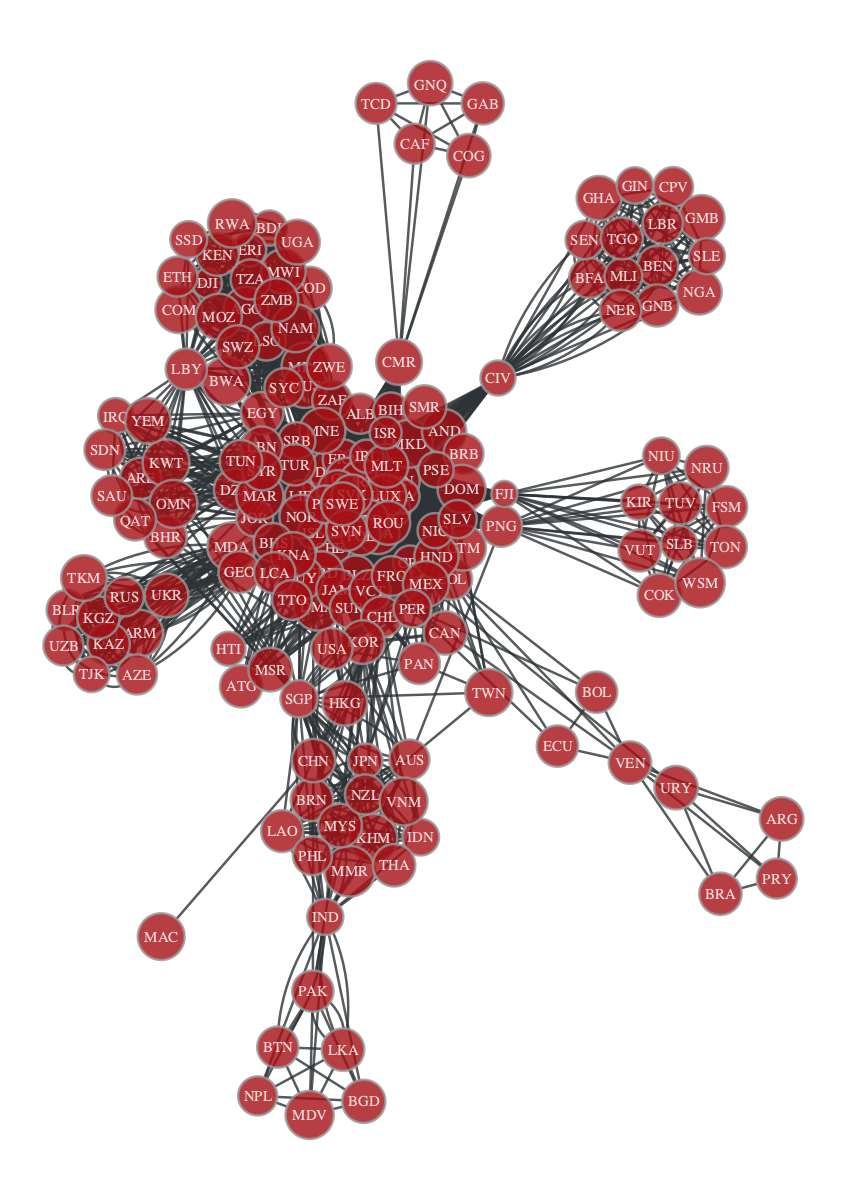

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28e46db80, at 0x28f5685b0>

In [40]:
gt.graph_draw(trade_graph, pos = pos, vertex_text = country)

I also add other information as properties to the graph. 
* Node color: region 
* Node size: economy size
* Edge size: PTA depth 

*Node color: region*

In [41]:
# list of unique country names and corresponding region
country1 = trade_df[['iso1']]
country2 = trade_df[['iso2']].rename(columns={'iso2': 'iso1'})

countries_all = pd.concat([country1, country2], ignore_index = True).drop_duplicates(keep='first')
countries_all = pd.merge(countries_all, regions, left_on='iso1', right_on='Code')[['iso1', 'Region_Clean']]

In [42]:
countries_all.loc[countries_all['iso1'] == 'KOR']

iso1         Region_Clean
92  KOR  East Asia & Pacific

In [43]:
# region-color dictionary  
region_colors = {'Sub-Saharan Africa':'#FFD573', # yellow
                 'Europe': '#7ACCE1', # blue
                 'Middle East & North Africa': '#FFD573', # yellow
                 'Latin America & Caribbean': '#90BC62', # green
                 'East Asia & Pacific': '#C7448C', # pink
                 'Central Asia': '#C7448C', # pink
                 'South Asia': '#C7448C', # pink
                 'North America': '#F78454'} # orange

# map colors to regions
countries_all['region_colors'] = countries_all['Region_Clean'].map(region_colors)

# country-color dictionary
country_colors = (
    countries_all[['iso1', 'region_colors']]
    .drop_duplicates()
    .set_index('iso1')
    .to_dict()['region_colors']
    )

In [44]:
# add color as node property
color = trade_graph.new_vertex_property('string')

for v in trade_graph.vertices():
    name = trade_graph.vp.country[v]
    try:
        color_map = country_colors.get(name,None)
    except KeyError:
        trade_graph.remove_vertex(v)
        continue
    color[v] = color_map

trade_graph.vertex_properties["color"] = color

*Edge size: depth*

In [45]:
# define edge size dictionary
edge_size = (
    trade_df[['sorted_iso', 'depth_norm']]
    .drop_duplicates()
    .set_index('sorted_iso')
    .to_dict()['depth_norm']
    )


In [46]:
# add depth as edge property
weight = trade_graph.new_edge_property('float')

for e in trade_graph.edges():
    name = trade_graph.ep.bilateral[e]
    if name in edge_size:
        weight[e] = edge_size[name]
    else:
        weight[e] = 0.0  # set default weight value to 0.0 if not found in the dictionary

trade_graph.edge_properties['weight'] = weight

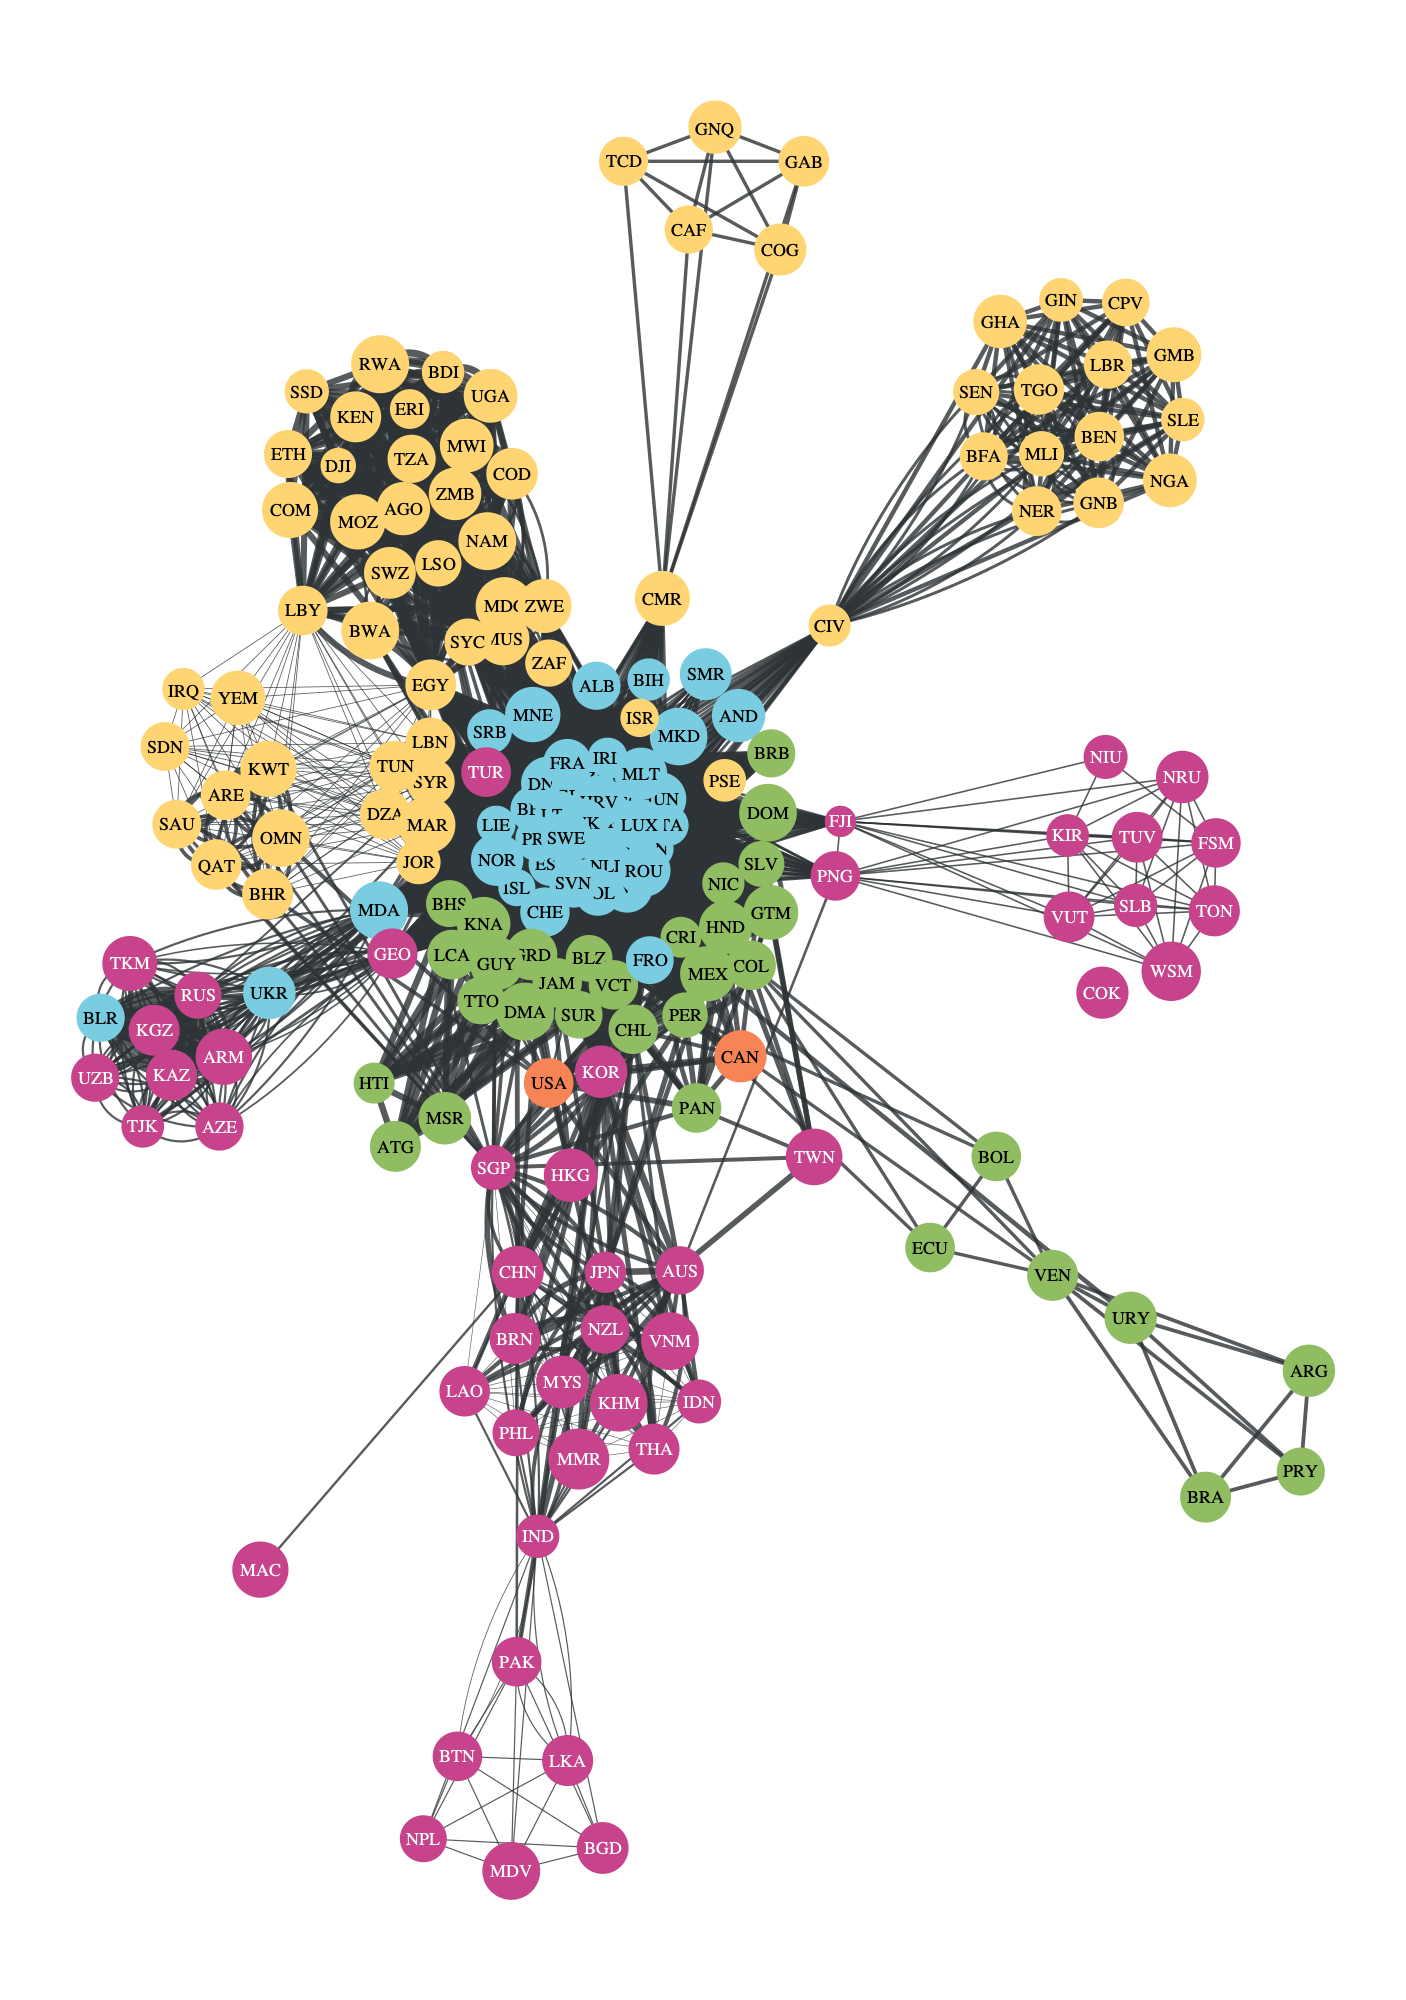

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28e46db80, at 0x1678f49d0>

In [99]:
gt.graph_draw(trade_graph, pos=pos, 
    vertex_fill_color=color, 
    vertex_size=15, 
    vertex_pen_width=0,
    vertex_text=country, 
    vertex_anchor=0,
    edge_pen_width=weight,
    output_size=(1000,1000))

*Node size: economy size*

In [27]:
plt.switch_backend("cairo")

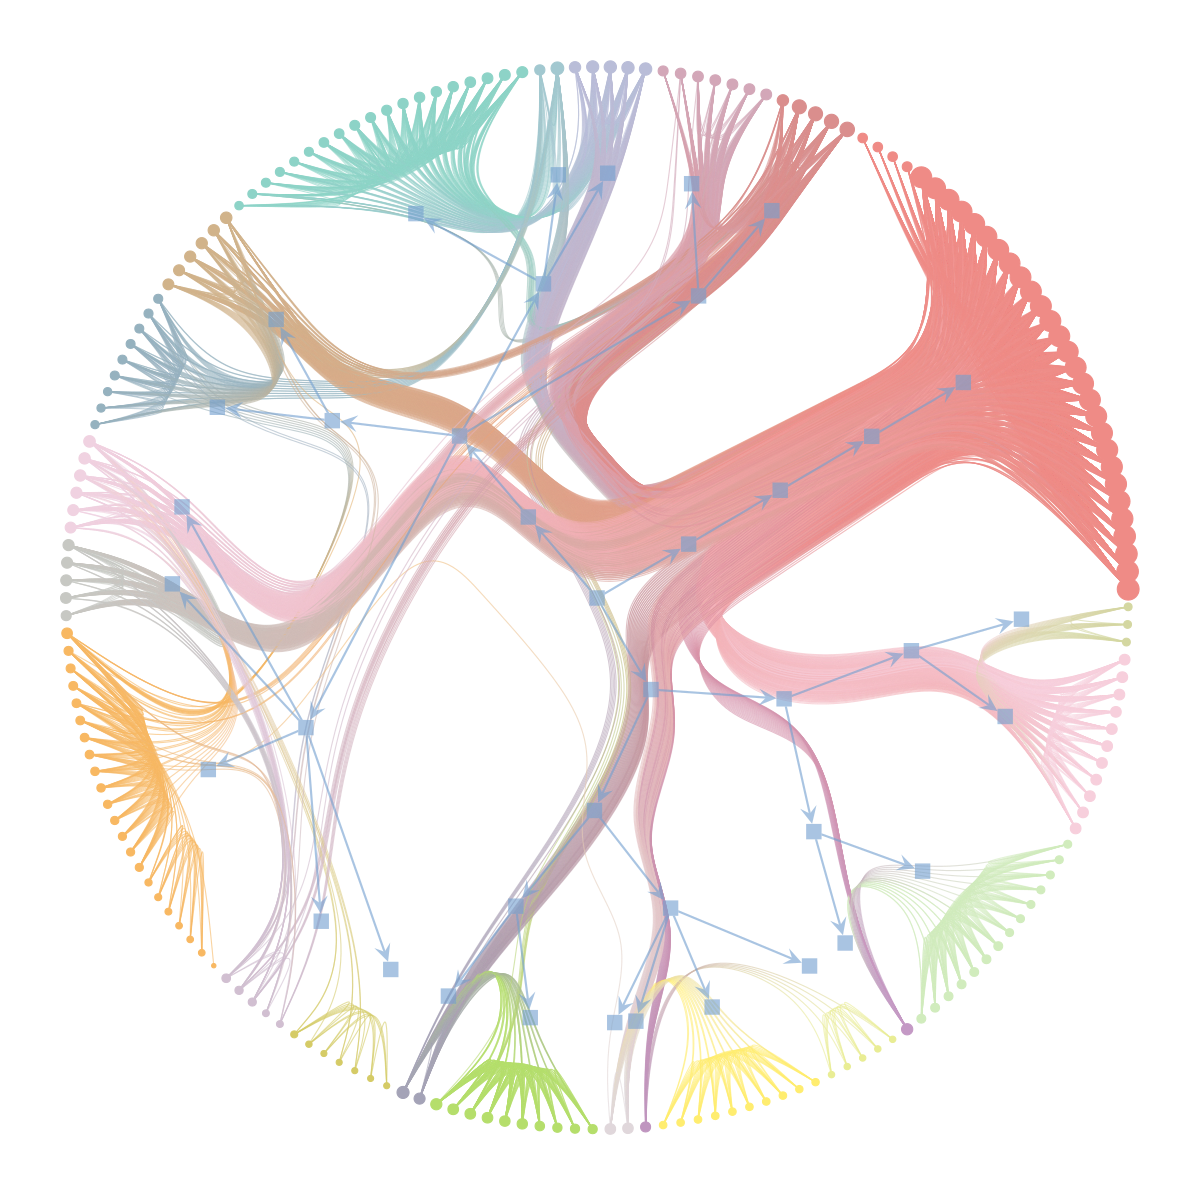

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28f06bee0, at 0x28ea15550>,
 <GraphView object, directed, with 229 vertices and 228 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x28ea15040, at 0x1678ecb50>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x28ea15040, at 0x1678ec9a0>, False), at 0x28ea15040>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x28ea15040, at 0x1678ec160>)

In [28]:
state = gt.minimize_nested_blockmodel_dl(trade_graph)
state.draw()

## III. By Region

In [101]:
def region_graph(df, output_size, depth=True):
    # prepare df
    nodes = df['iso1'].drop_duplicates()
    pairs = df[['iso1', 'iso2', 'agreement']].drop_duplicates(keep='first')
    pairs = list(zip(pairs.iso1, pairs.iso2))

    # create graph object
    graph = gt.Graph(directed=False)
    country = graph.new_vertex_property('string')
    bilateral = graph.new_edge_property('object')

    node_list = {}
    for pair in pairs:
        for name in pair:
            if name not in node_list:
                v = graph.add_vertex()
                node_list[name] = v
                country[v] = name
        e = graph.add_edge(node_list[pair[0]], node_list[pair[1]])
        bilateral[e] = (pair[0], pair[1]) 

    graph.vertex_properties["country"] = country
    graph.edge_properties["bilateral"] = bilateral

    # add color property
    color = graph.new_vertex_property('string')

    for v in graph.vertices():
        name = graph.vp.country[v]
        try:
            color_map = country_colors.get(name,None)
        except KeyError:
            graph.remove_vertex(v)
            continue
        color[v] = color_map

    graph.vertex_properties["color"] = color

    # add edge size property
    weight = graph.new_edge_property('float')

    for e in graph.edges():
        name = graph.ep.bilateral[e]
        if name in edge_size:
            weight[e] = edge_size[name]
        else:
            weight[e] = 0.0  # set default weight value to 0.0 if not found in the dictionary

    graph.edge_properties['weight'] = weight

    if depth:
        gt.graph_draw(graph, pos=pos, 
            vertex_fill_color=color, 
            vertex_size=15, 
            vertex_pen_width=0,
            vertex_text=country, 
            vertex_anchor=0,
            edge_pen_width=weight,
            output_size=output_size)
    else:
        gt.graph_draw(graph, pos=pos, 
            vertex_fill_color=color, 
            vertex_size=15, 
            vertex_pen_width=0,
            vertex_text=country, 
            vertex_anchor=0,
            edge_pen_width=0.8,
            output_size=output_size)

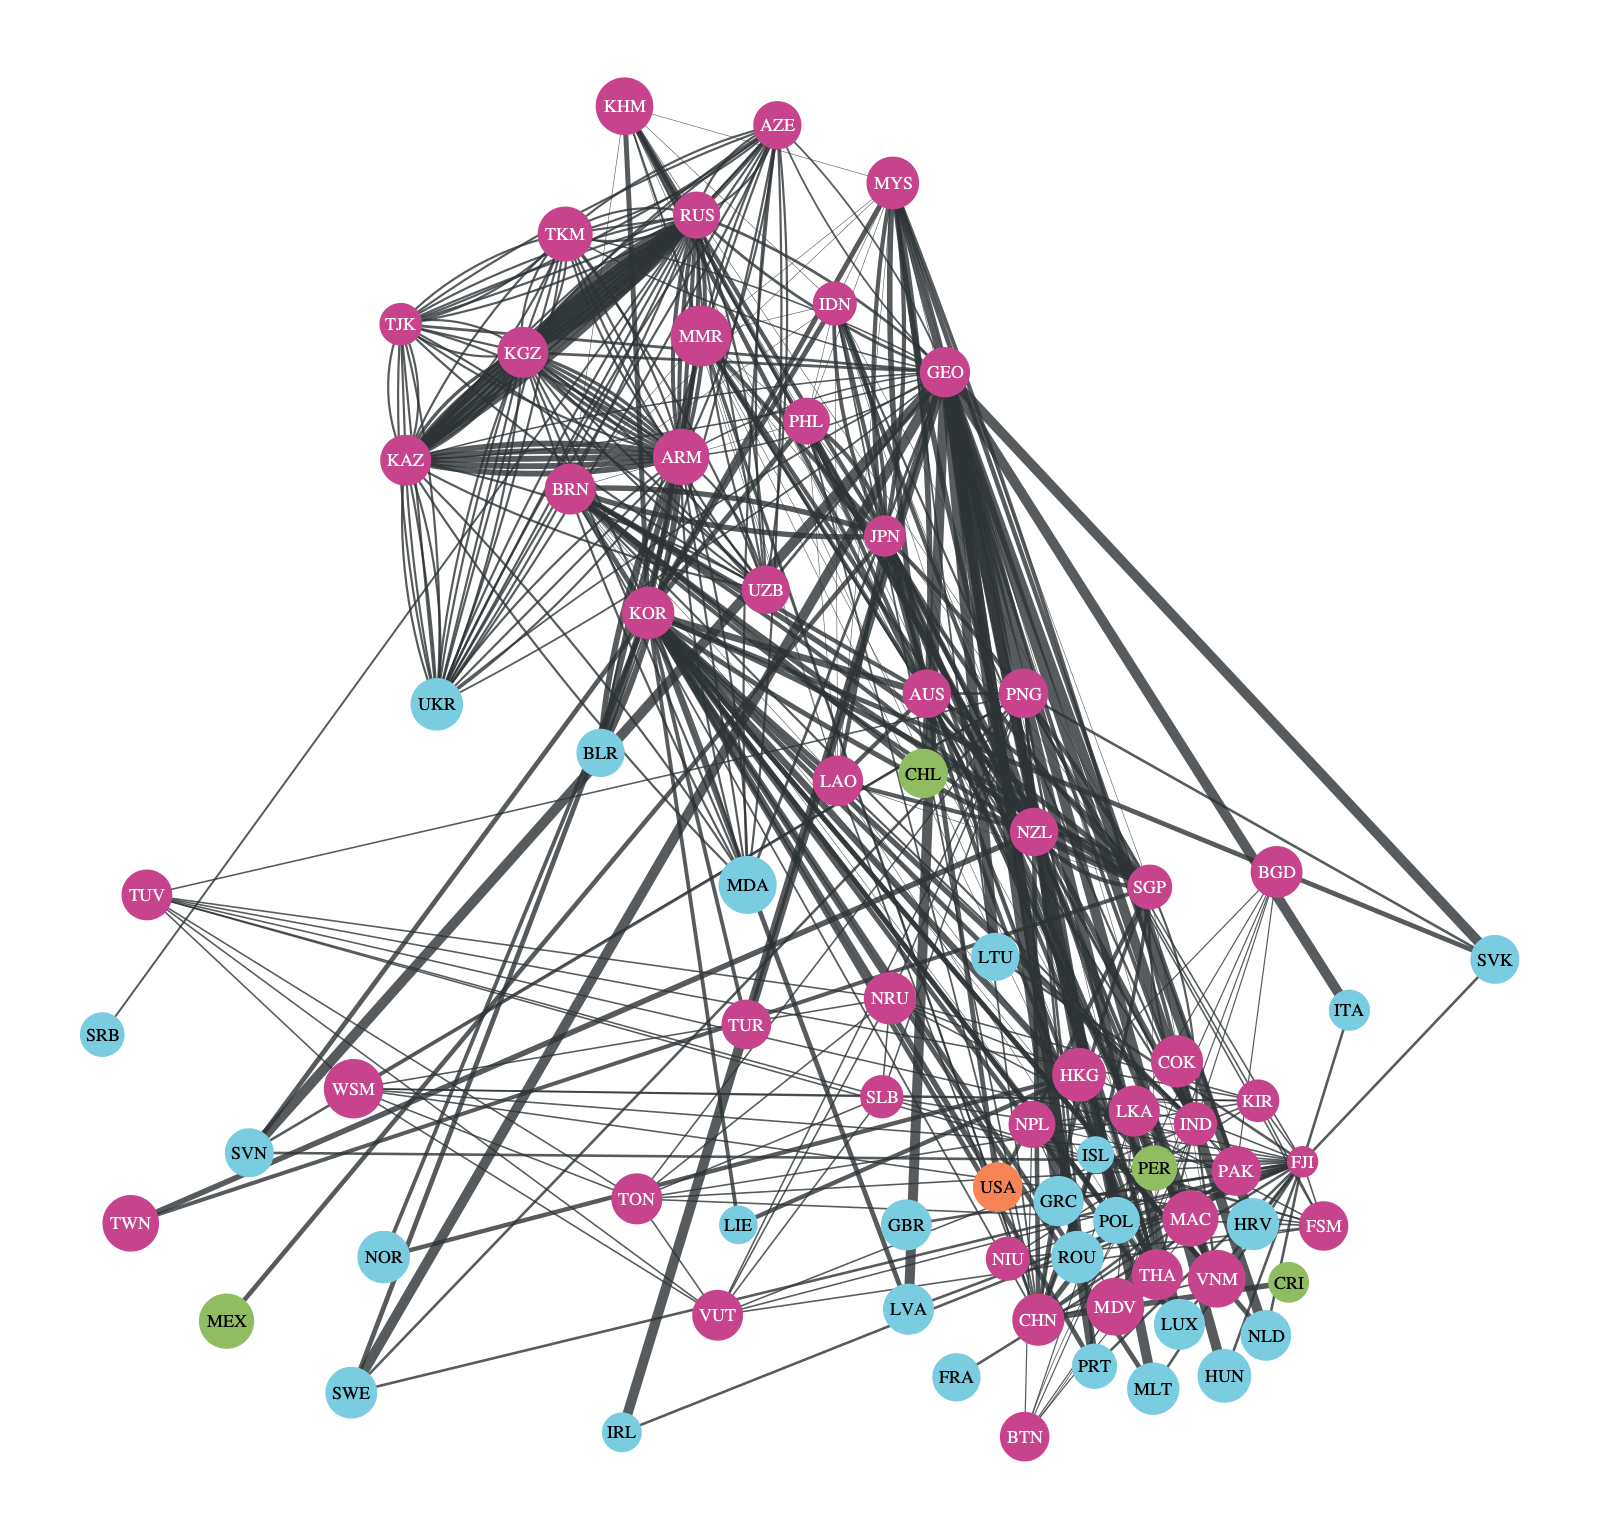

In [102]:
asia_df = trade_df[trade_df['Region_Clean'].isin(['South Asia', 'East Asia & Pacific', 'Central Asia'])]
region_graph(asia_df, (800,800), depth=True)

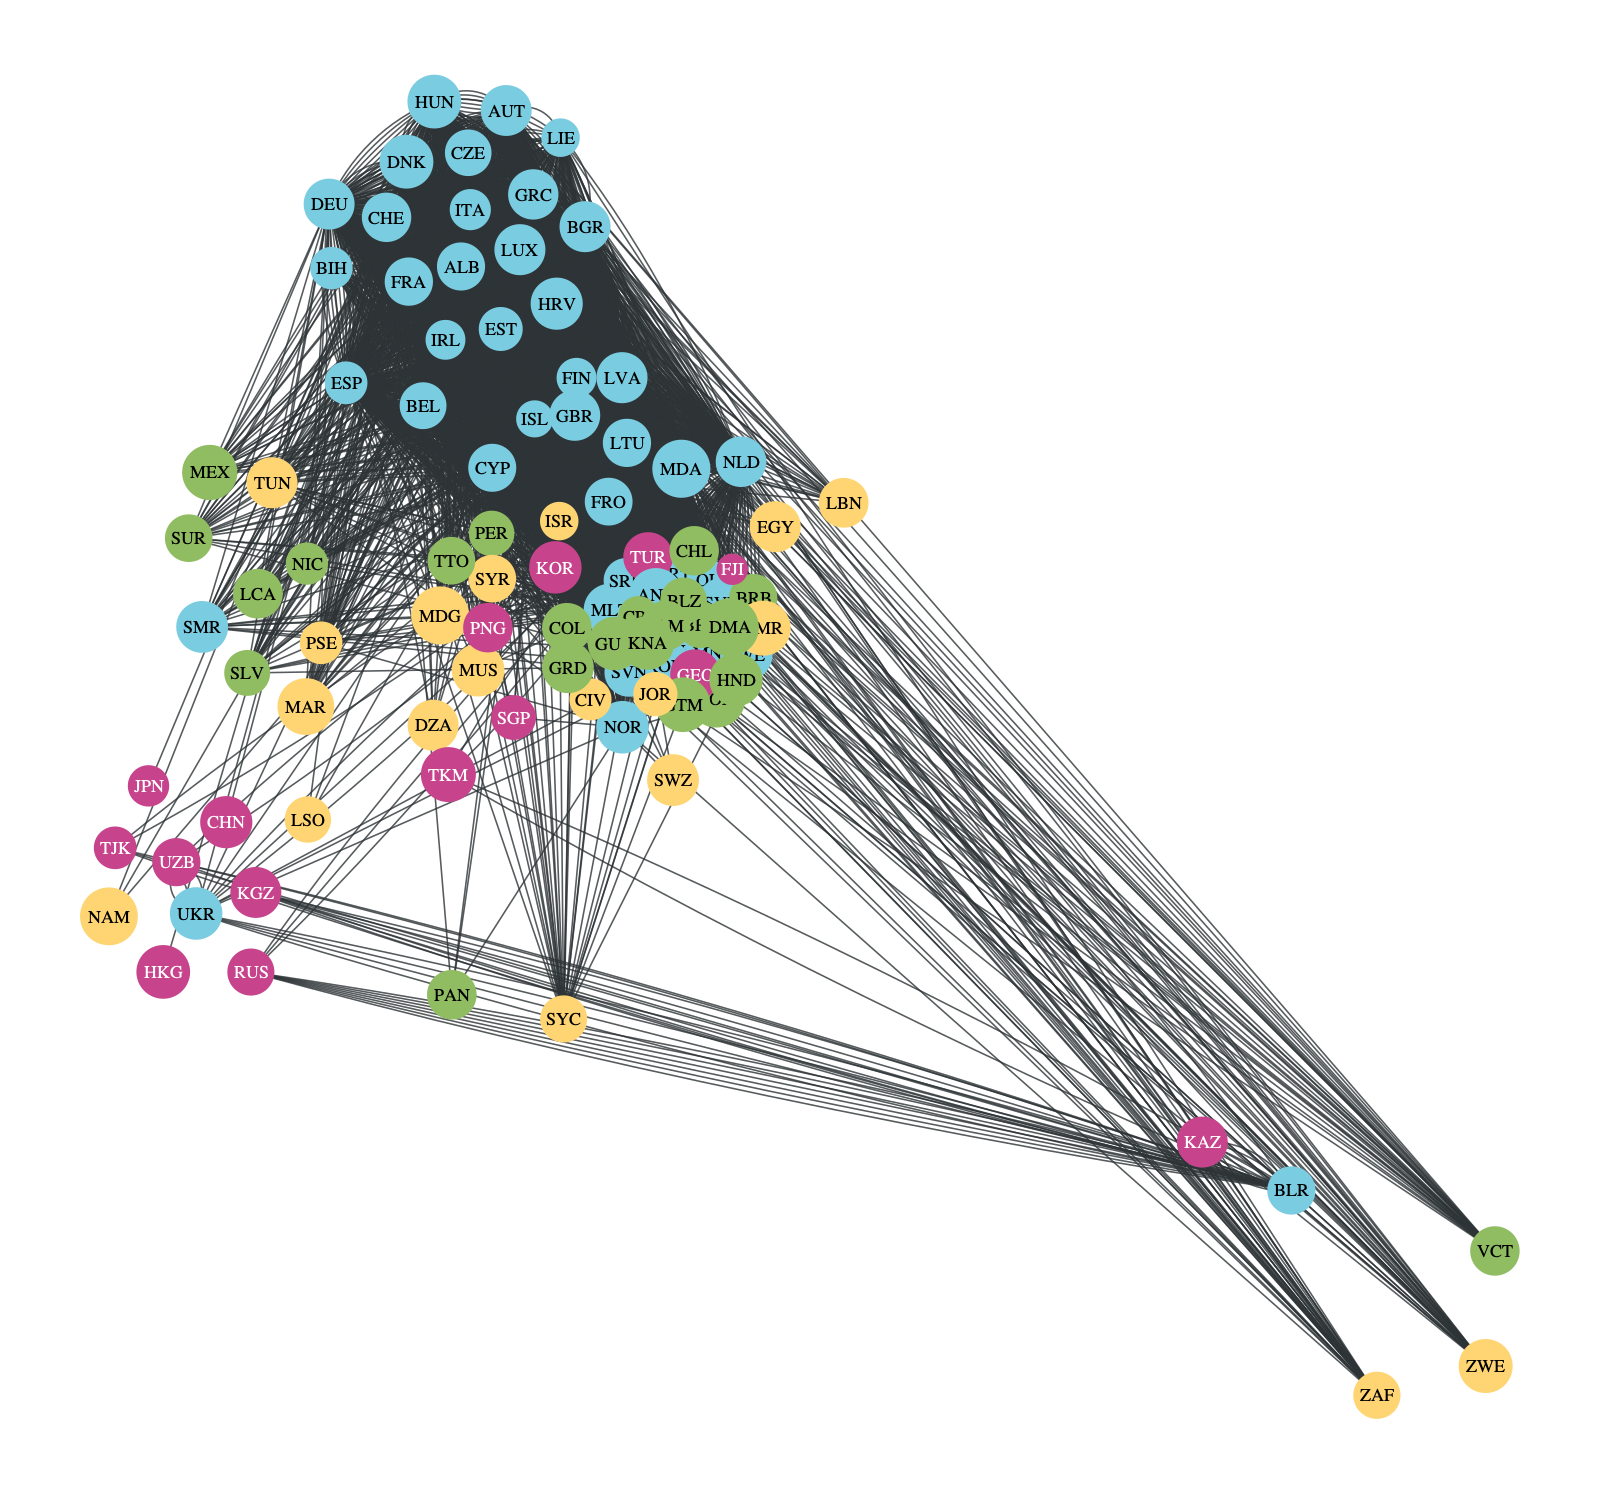

In [103]:
europe_df = trade_df[trade_df['Region_Clean'].isin(['Europe'])]
region_graph(europe_df, (800,800), depth=False)

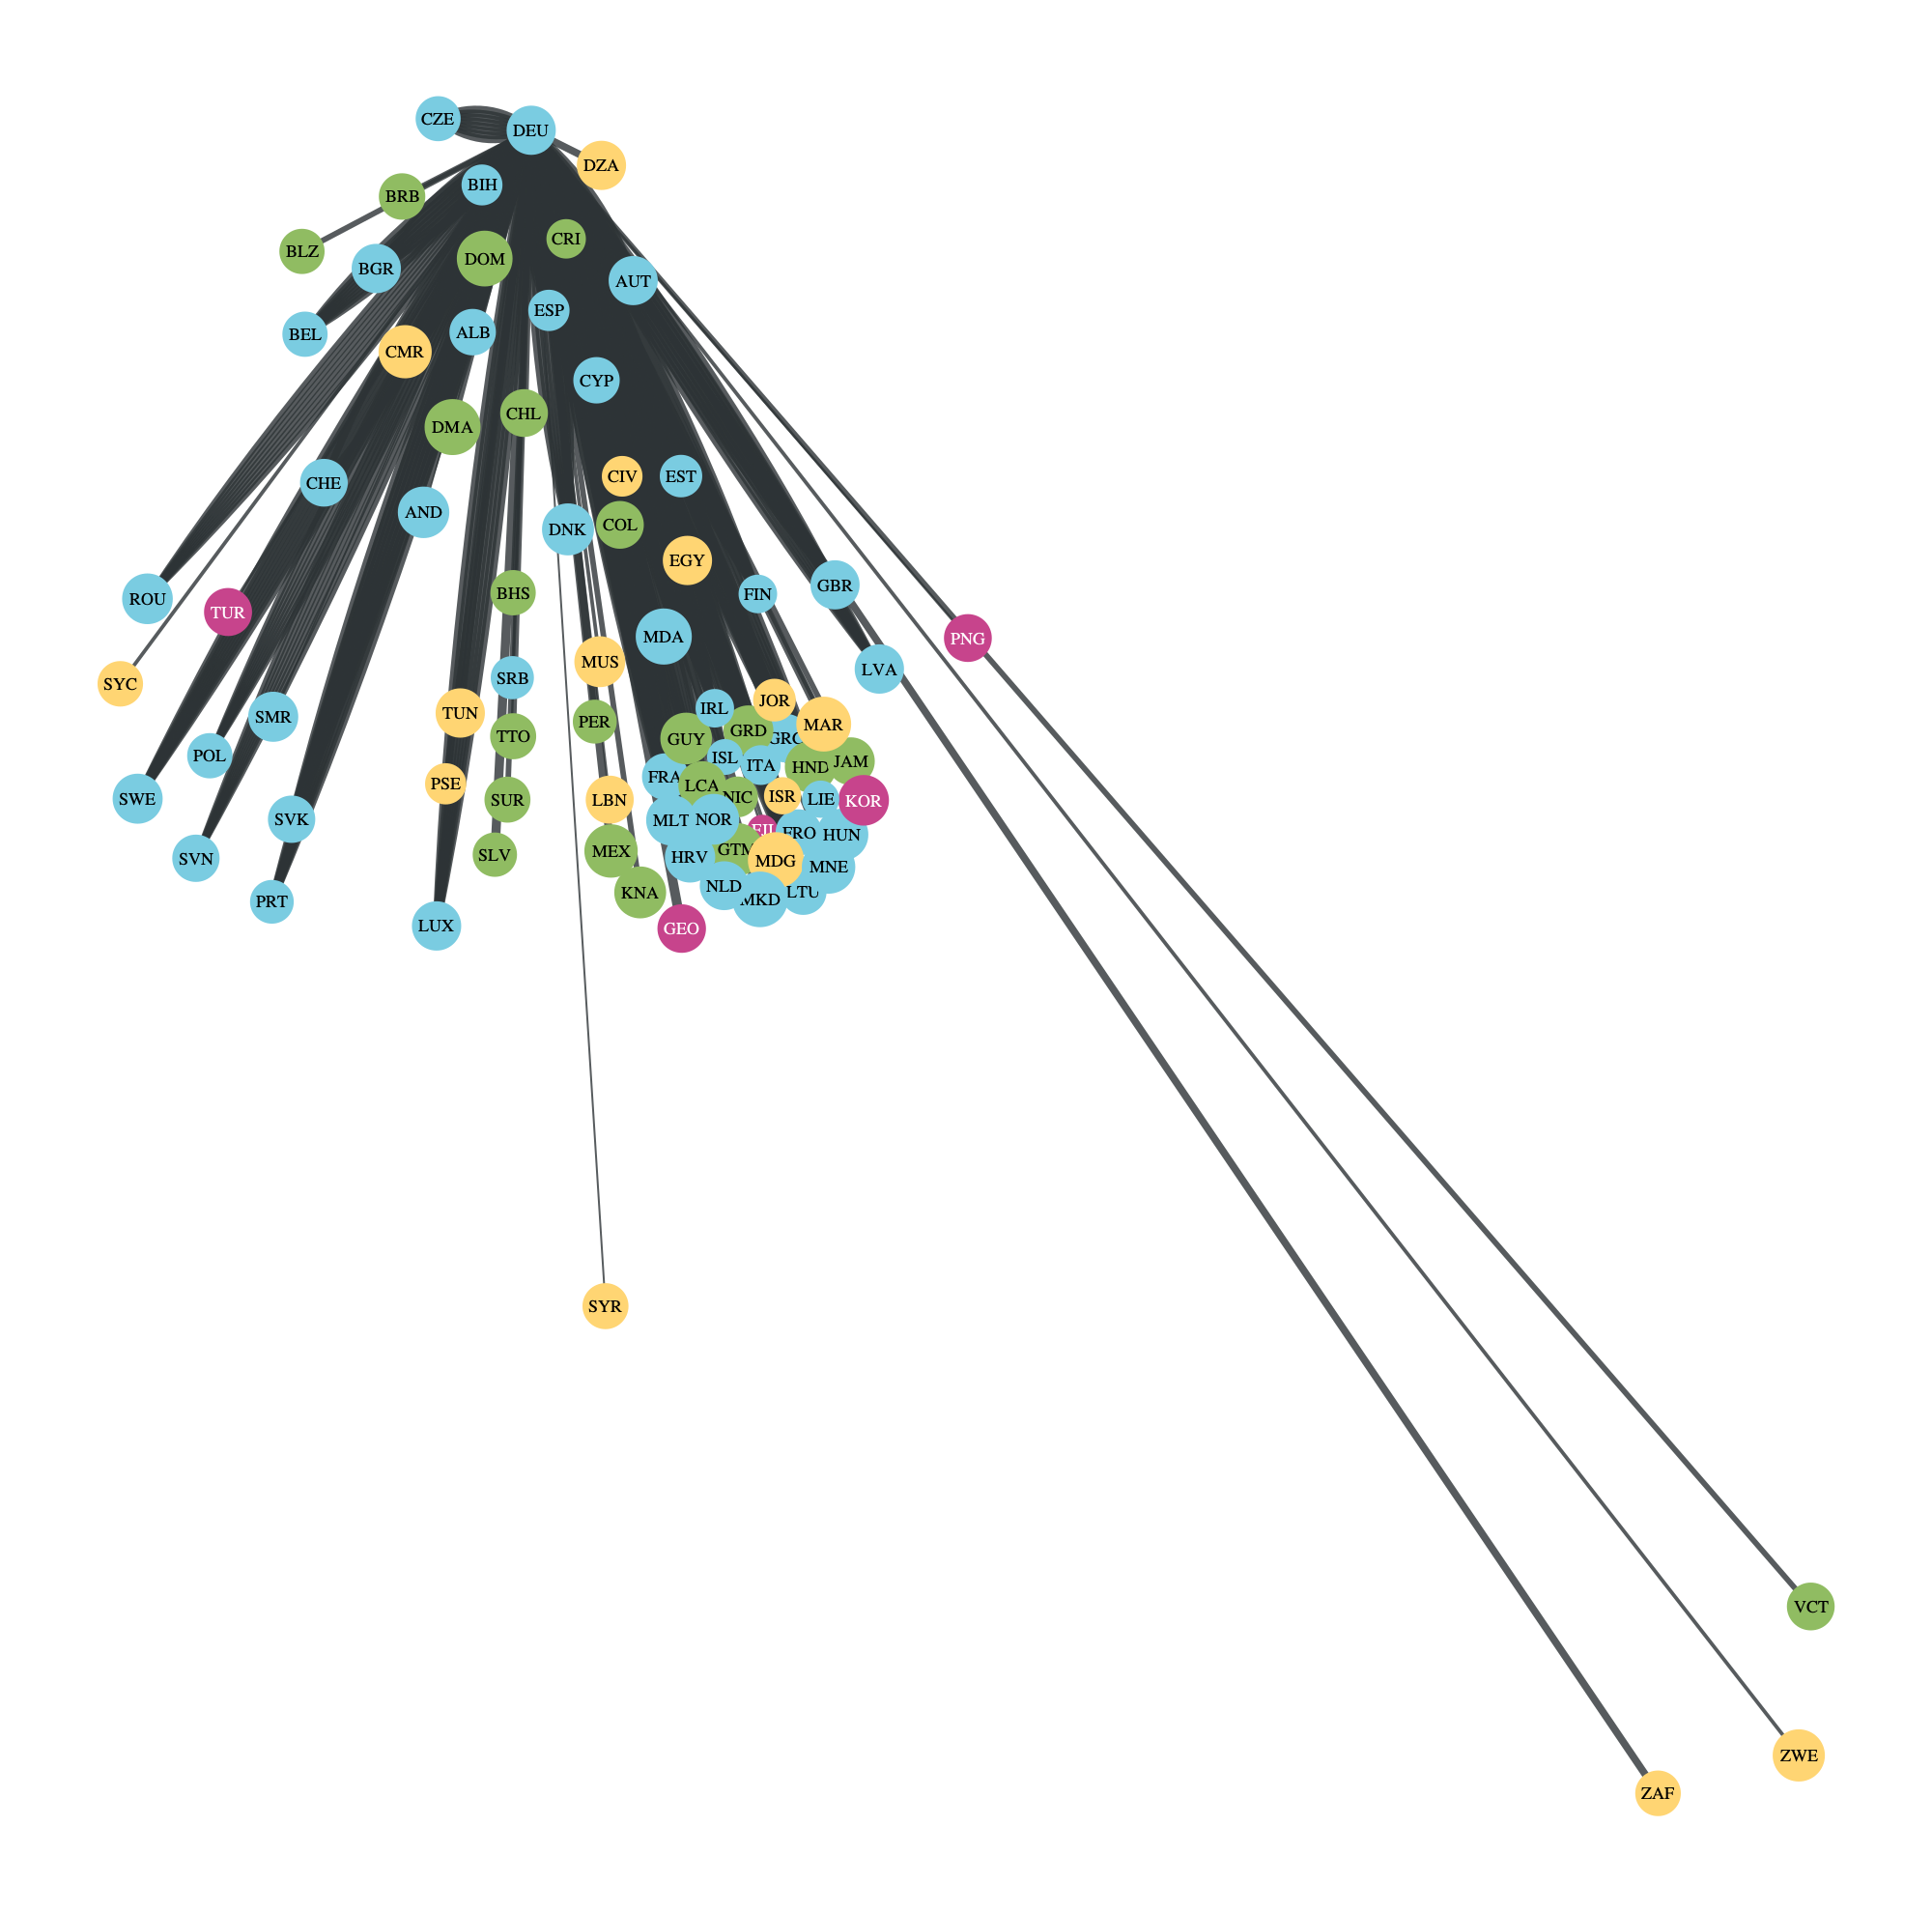

In [104]:
deu_df = trade_df[(trade_df['iso1'] == 'DEU') | (trade_df['iso2'] == 'DEU')]
region_graph(deu_df, (1000,1000))